In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
df=pd.read_csv('cell1.csv')
df = df.sort_values('t')
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (426883, 5)


,Unnamed: 0,t,v,q,T
3510,0,735954.8172,4.1912,0.0000,40.0265
3511,1,735954.8172,4.1758,-0.1948,40.0514
3512,2,735954.8172,4.1743,-0.3998,39.9890
3513,3,735954.8173,4.1726,-0.6047,39.9765
3514,4,735954.8173,4.1715,-0.8097,39.9641


Approx 1.2% of value in Global_active_power column are missing, it is not a big deal, I decided to remove them.

In [3]:
print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.t.min())
print('The time series ends on: ', df.t.max())

Number of rows and columns after removing missing values: (426883, 5)
The time series starts from:  735954.8172255821
The time series ends on:  736593.489528597


After removing the missing values, the data contains 2049280 measurements gathered between December 2006 and November 2010 (47 months).

The initial data contains several variables. We will here focus on a single value : a house's Global_active_power history, that is, household global minute-averaged active power in kilowatt.

### Statistical Normality Test

There are several statistical tests that we can use to quantify whether our data looks as though it was drawn from a Gaussian distribution. And we will use D’Agostino’s K^2 Test.

In the SciPy implementation of the test, we will interpret the p value as follows.

* p <= alpha: reject H0, not normal.
* p > alpha: fail to reject H0, normal.

We can also calculate kurtosis and skewness, to determine if the data distribution departs from the normal distribution.

Kurtosis of normal distribution: -1.1442202653349849
Skewness of normal distribution: 0.004347556695992994


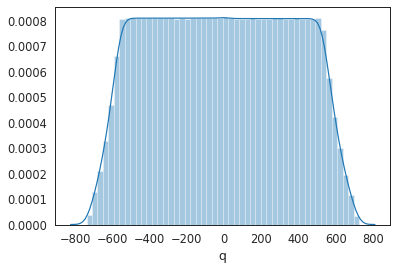

In [4]:
# print(df.Global_active_power.describe())
sns.distplot(df.q);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.q)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.q)))

KURTOSIS: describes heaviness of the tails of a distribution

Normal Distribution has a kurtosis of close to 0.  If the kurtosis is greater than zero, then distribution has heavier tails. If the kurtosis is less than zero, then the distribution is light tails. And our Kurtosis is greater than zero. 

SKEWNESS:

If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed. If the skewness is less than -1 or greater than 1, the data are highly skewed. And our skewness is greater than 1.

### First Time series plot

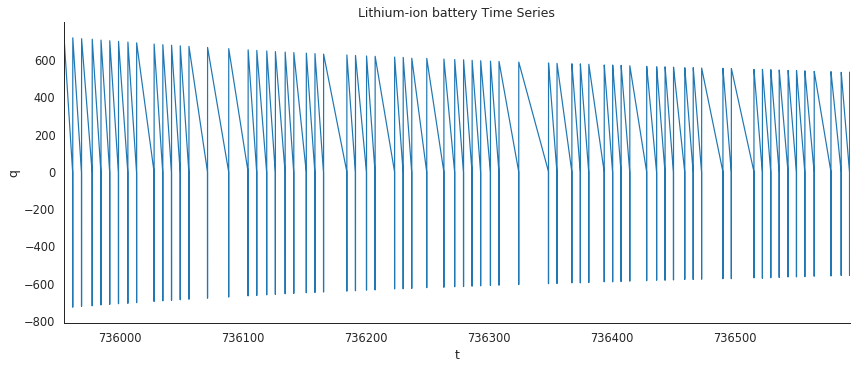

In [5]:
df1=df.loc[:,['t','q']]
df1.set_index('t',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('q')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Lithium-ion battery Time Series')
sns.despine(top=True)
plt.show();

## LSTM

Create dataset, normalize the dataset, split into training and test sets, convert an array of values into a dataset matrix

In [6]:
dataset = df.q.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [7]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [8]:
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [9]:
X_train.shape

(341475, 30)

In [10]:
Y_train.shape

(341475,)

In [11]:
X_test.shape

(85346, 30)

In [12]:
Y_test.shape

(85346,)

In [13]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

### Model Architecture

In [14]:
X_train.shape

(341475, 1, 30)

In [15]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=10, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 341475 samples, validate on 85346 samples
Epoch 1/10
341475/341475 [==============================] - 27s 79us/step - loss: 0.0072 - val_loss: 0.0131
Epoch 2/10
341475/341475 [==============================] - 16s 47us/step - loss: 0.0045 - val_loss: 0.0120
Epoch 3/10
341475/341475 [==============================] - 15s 44us/step - loss: 0.0027 - val_loss: 0.0045
Epoch 4/10
341475/341475 [==============================] - 17s 49us/step - loss: 0.0019 - val_loss: 0.0037
Epoch 5/10
341475/341475 [==============================] - 17s 49us/step - loss: 0.0016 - val_loss: 0.0025
Epoch 6/10
341475/341475 [==============================] - 17s 50us/step - loss: 0.0013 - val_loss: 0.0029
Epoch 7/10
341475/341475 [==============================] - 17s 50us/step - loss: 0.0010 - val_loss: 0.0018
Epoch 8/10
341475/341475 [==============================] - 17s 49us/step

In [16]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 34.29566590151075
Train Root Mean Squared Error: 46.86888985331805
Test Mean Absolute Error: 29.42038774676394
Test Root Mean Squared Error: 40.787904953923764


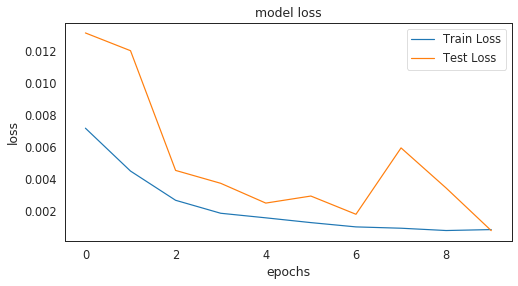

In [17]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

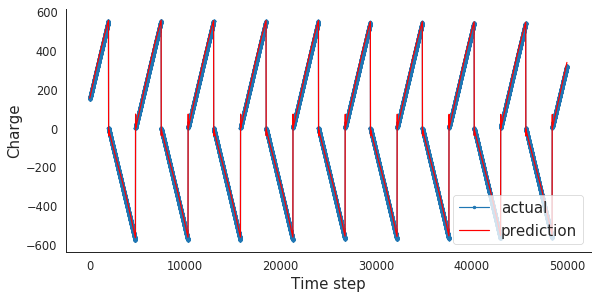

In [26]:
aa=[x for x in range(50000)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:50000], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:50000], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Charge', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

# cell2

Number of rows and columns: (398330, 4)
Kurtosis of normal distribution: -1.1309840344769533
Skewness of normal distribution: 0.005876795533729902


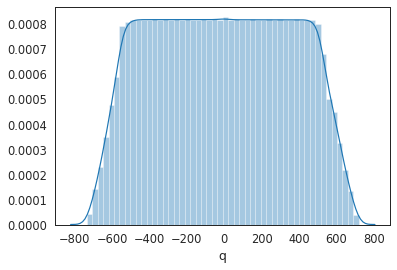

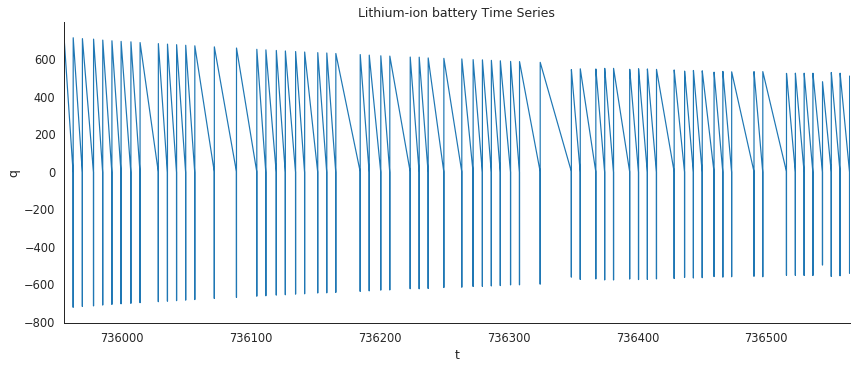

Train on 318633 samples, validate on 79635 samples
Epoch 1/10
318633/318633 [==============================] - 18s 55us/step - loss: 0.0075 - val_loss: 0.0046
Epoch 2/10
318633/318633 [==============================] - 16s 50us/step - loss: 0.0043 - val_loss: 0.0053
Epoch 3/10
318633/318633 [==============================] - 16s 51us/step - loss: 0.0027 - val_loss: 0.0035
Epoch 4/10
318633/318633 [==============================] - 16s 51us/step - loss: 0.0019 - val_loss: 0.0032
Epoch 5/10
318633/318633 [==============================] - 16s 50us/step - loss: 0.0016 - val_loss: 0.0029
Epoch 6/10
318633/318633 [==============================] - 16s 50us/step - loss: 0.0014 - val_loss: 0.0024
Epoch 7/10
318633/318633 [==============================] - 16s 50us/step - loss: 0.0011 - val_loss: 0.0016
Epoch 8/10
318633/318633 [==============================] - 17s 53us/step - loss: 9.5139e-04 - val_loss: 0.0014
Epoch 9/10
318633/318633 [==============================] - 16s 50us/step - loss:

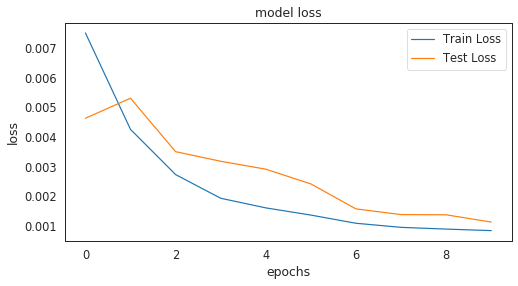

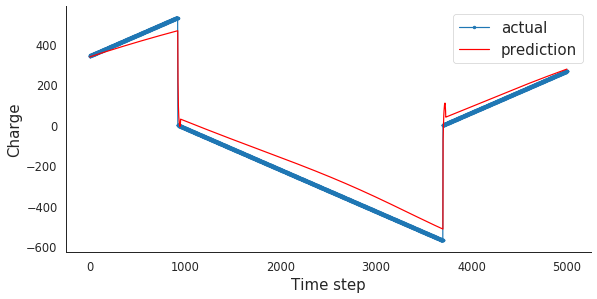

In [19]:
df=pd.read_csv('cell2.csv')
df = df.sort_values('t')
print('Number of rows and columns:', df.shape)
df.head(5)
# print(df.Global_active_power.describe())
sns.distplot(df.q);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.q)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.q)))
df1=df.loc[:,['t','q']]
df1.set_index('t',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('q')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Lithium-ion battery Time Series')
sns.despine(top=True)
plt.show();
dataset = df.q.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=10, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();
aa=[x for x in range(5000)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:5000], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:5000], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Charge', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

# cell3

Number of rows and columns: (418201, 4)
Kurtosis of normal distribution: -1.1491339650167247
Skewness of normal distribution: 0.004004717098967917


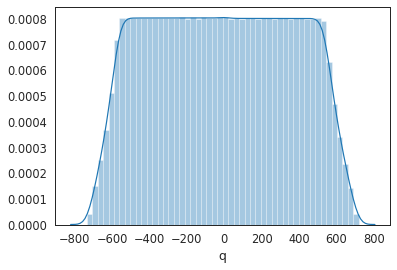

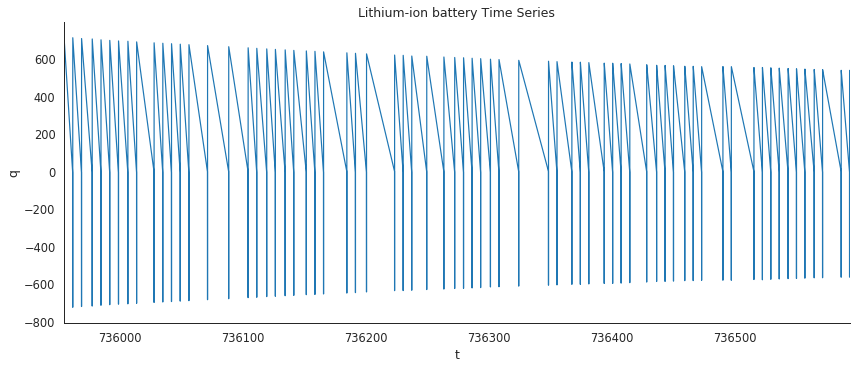

Train on 334529 samples, validate on 83610 samples
Epoch 1/10
334529/334529 [==============================] - 19s 56us/step - loss: 0.0072 - val_loss: 0.0029
Epoch 2/10
334529/334529 [==============================] - 17s 51us/step - loss: 0.0043 - val_loss: 0.0053
Epoch 3/10
334529/334529 [==============================] - 17s 52us/step - loss: 0.0028 - val_loss: 0.0035
Epoch 4/10
334529/334529 [==============================] - 18s 53us/step - loss: 0.0019 - val_loss: 0.0031
Epoch 5/10
334529/334529 [==============================] - 19s 58us/step - loss: 0.0016 - val_loss: 0.0024
Epoch 6/10
334529/334529 [==============================] - 17s 51us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/10
334529/334529 [==============================] - 17s 51us/step - loss: 0.0010 - val_loss: 0.0016
Epoch 8/10
334529/334529 [==============================] - 17s 50us/step - loss: 8.1164e-04 - val_loss: 1.5906e-04
Epoch 9/10
334529/334529 [==============================] - 17s 51us/step - l

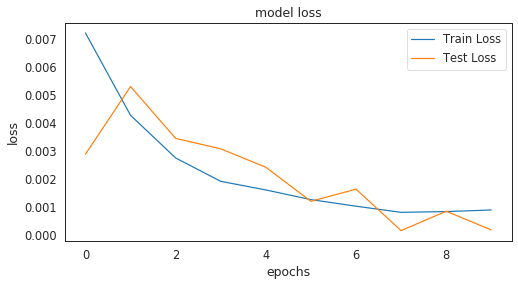

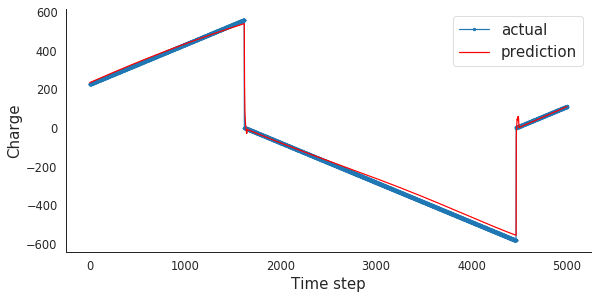

In [20]:
df=pd.read_csv('cell3.csv')
df = df.sort_values('t')
print('Number of rows and columns:', df.shape)
df.head(5)
# print(df.Global_active_power.describe())
sns.distplot(df.q);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.q)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.q)))
df1=df.loc[:,['t','q']]
df1.set_index('t',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('q')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Lithium-ion battery Time Series')
sns.despine(top=True)
plt.show();
dataset = df.q.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=10, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();
aa=[x for x in range(5000)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:5000], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:5000], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Charge', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

# cell4

Number of rows and columns: (265776, 4)
Kurtosis of normal distribution: -1.15849400283346
Skewness of normal distribution: 0.0025961482359459368


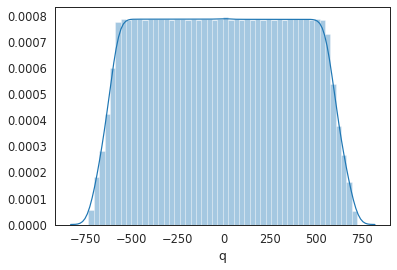

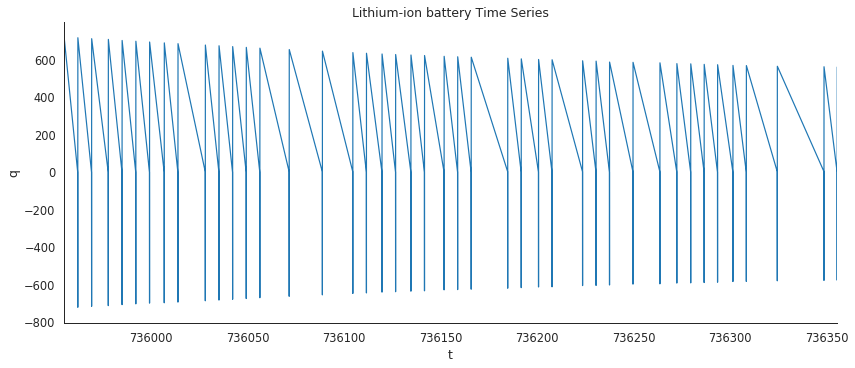

Train on 212589 samples, validate on 53125 samples
Epoch 1/10
212589/212589 [==============================] - 12s 58us/step - loss: 0.0096 - val_loss: 0.0156
Epoch 2/10
212589/212589 [==============================] - 11s 52us/step - loss: 0.0046 - val_loss: 0.0202
Epoch 3/10
212589/212589 [==============================] - 11s 51us/step - loss: 0.0042 - val_loss: 0.0155
Epoch 4/10
212589/212589 [==============================] - 11s 52us/step - loss: 0.0030 - val_loss: 0.0102
Epoch 5/10
212589/212589 [==============================] - 11s 53us/step - loss: 0.0023 - val_loss: 0.0068
Epoch 6/10
212589/212589 [==============================] - 11s 52us/step - loss: 0.0019 - val_loss: 0.0060
Epoch 7/10
212589/212589 [==============================] - 11s 51us/step - loss: 0.0017 - val_loss: 0.0059
Epoch 8/10
212589/212589 [==============================] - 11s 52us/step - loss: 0.0016 - val_loss: 0.0043
Epoch 9/10
212589/212589 [==============================] - 11s 52us/step - loss: 0.0

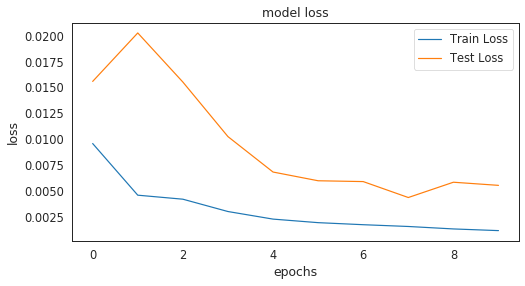

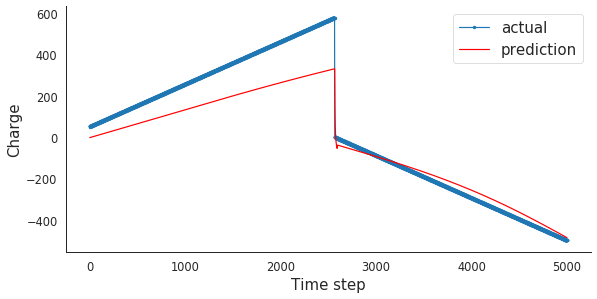

In [21]:
df=pd.read_csv('cell4.csv')
df = df.sort_values('t')
print('Number of rows and columns:', df.shape)
df.head(5)
# print(df.Global_active_power.describe())
sns.distplot(df.q);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.q)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.q)))
df1=df.loc[:,['t','q']]
df1.set_index('t',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('q')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Lithium-ion battery Time Series')
sns.despine(top=True)
plt.show();
dataset = df.q.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=10, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();
aa=[x for x in range(5000)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:5000], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:5000], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Charge', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

# cell5

Number of rows and columns: (264166, 4)
Kurtosis of normal distribution: -1.1649117210679816
Skewness of normal distribution: 0.002975833011871369


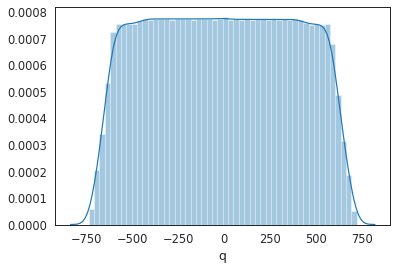

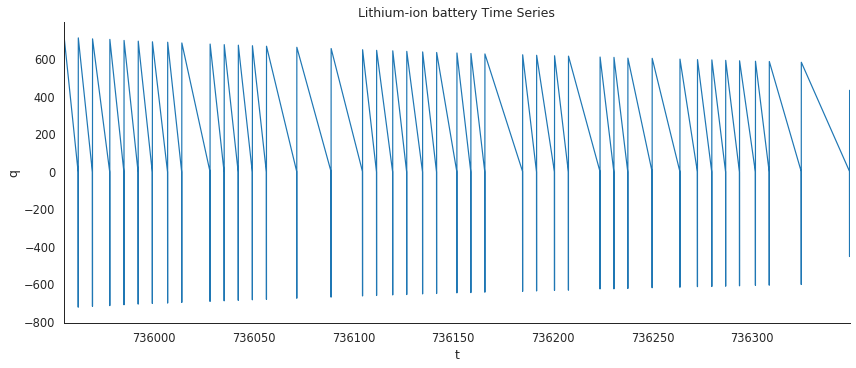

Train on 211301 samples, validate on 52803 samples
Epoch 1/10
211301/211301 [==============================] - 12s 58us/step - loss: 0.0093 - val_loss: 0.0026
Epoch 2/10
211301/211301 [==============================] - 11s 52us/step - loss: 0.0049 - val_loss: 0.0033
Epoch 3/10
211301/211301 [==============================] - 11s 52us/step - loss: 0.0043 - val_loss: 0.0040
Epoch 4/10
211301/211301 [==============================] - 11s 52us/step - loss: 0.0031 - val_loss: 0.0043
Epoch 5/10
211301/211301 [==============================] - 11s 52us/step - loss: 0.0023 - val_loss: 0.0034
Epoch 6/10
211301/211301 [==============================] - 11s 52us/step - loss: 0.0020 - val_loss: 0.0028
Epoch 7/10
211301/211301 [==============================] - 11s 52us/step - loss: 0.0018 - val_loss: 0.0030
Epoch 8/10
211301/211301 [==============================] - 11s 51us/step - loss: 0.0016 - val_loss: 0.0027
Epoch 9/10
211301/211301 [==============================] - 11s 52us/step - loss: 0.0

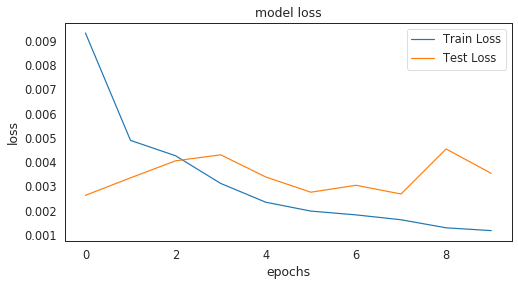

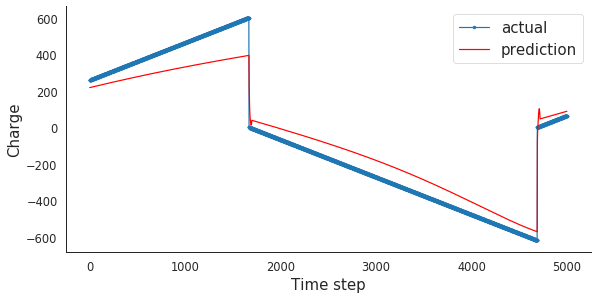

In [22]:
df=pd.read_csv('cell5.csv')
df = df.sort_values('t')
print('Number of rows and columns:', df.shape)
df.head(5)
# print(df.Global_active_power.describe())
sns.distplot(df.q);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.q)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.q)))
df1=df.loc[:,['t','q']]
df1.set_index('t',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('q')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Lithium-ion battery Time Series')
sns.despine(top=True)
plt.show();
dataset = df.q.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=10, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();
aa=[x for x in range(5000)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:5000], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:5000], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Charge', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

# cell6

Number of rows and columns: (263322, 4)
Kurtosis of normal distribution: -1.168322099480507
Skewness of normal distribution: 0.00030126155112430465


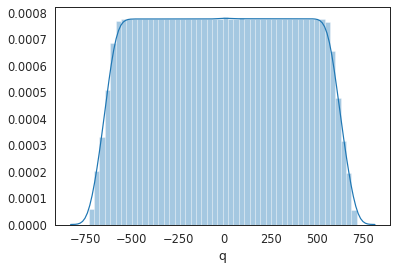

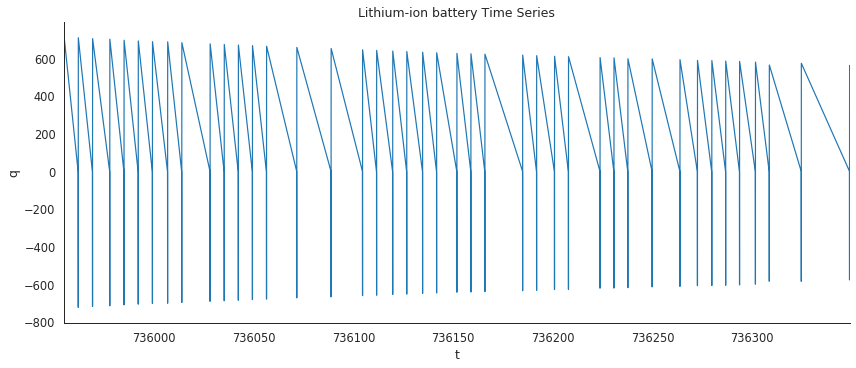

Train on 210626 samples, validate on 52634 samples
Epoch 1/10
210626/210626 [==============================] - 12s 58us/step - loss: 0.0096 - val_loss: 0.0044
Epoch 2/10
210626/210626 [==============================] - 11s 52us/step - loss: 0.0047 - val_loss: 0.0048
Epoch 3/10
210626/210626 [==============================] - 11s 52us/step - loss: 0.0041 - val_loss: 0.0055
Epoch 4/10
210626/210626 [==============================] - 11s 52us/step - loss: 0.0031 - val_loss: 0.0044
Epoch 5/10
210626/210626 [==============================] - 11s 53us/step - loss: 0.0023 - val_loss: 0.0034
Epoch 6/10
210626/210626 [==============================] - 11s 52us/step - loss: 0.0019 - val_loss: 0.0035
Epoch 7/10
210626/210626 [==============================] - 11s 52us/step - loss: 0.0017 - val_loss: 0.0029
Epoch 8/10
210626/210626 [==============================] - 11s 52us/step - loss: 0.0015 - val_loss: 0.0027
Epoch 9/10
210626/210626 [==============================] - 11s 52us/step - loss: 0.0

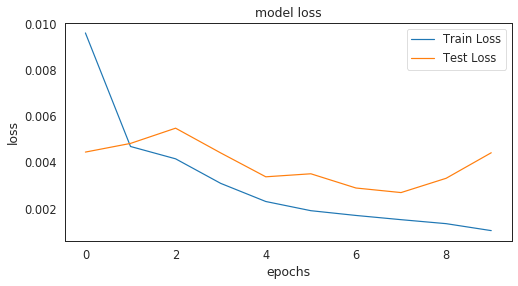

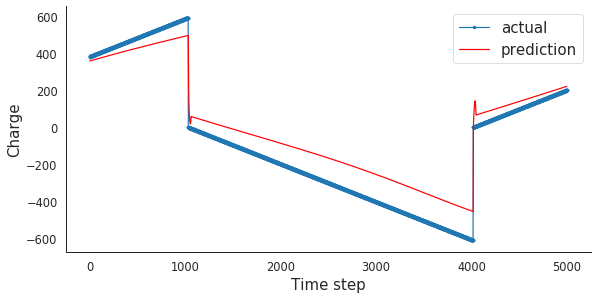

In [23]:
df=pd.read_csv('cell6.csv')
df = df.sort_values('t')
print('Number of rows and columns:', df.shape)
df.head(5)
# print(df.Global_active_power.describe())
sns.distplot(df.q);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.q)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.q)))
df1=df.loc[:,['t','q']]
df1.set_index('t',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('q')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Lithium-ion battery Time Series')
sns.despine(top=True)
plt.show();
dataset = df.q.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=10, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();
aa=[x for x in range(5000)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:5000], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:5000], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Charge', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

# cell7

Number of rows and columns: (430372, 4)
Kurtosis of normal distribution: -1.1650175766248678
Skewness of normal distribution: 0.0022268470863387744


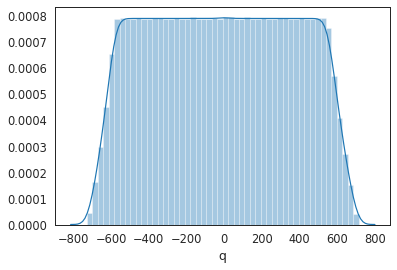

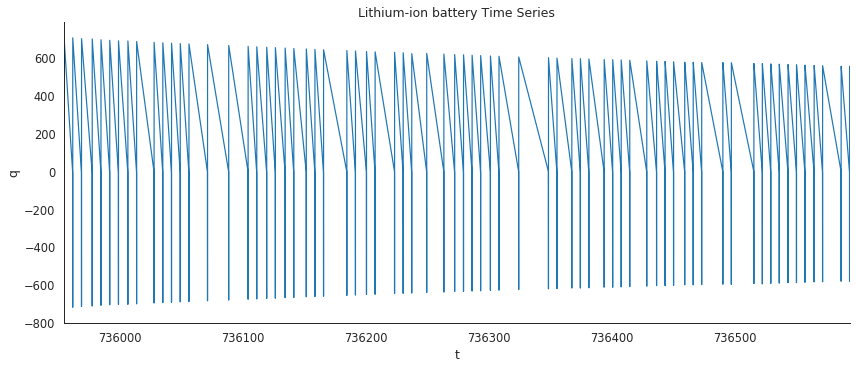

Train on 344266 samples, validate on 86044 samples
Epoch 1/10
344266/344266 [==============================] - 19s 56us/step - loss: 0.0074 - val_loss: 0.0036
Epoch 2/10
344266/344266 [==============================] - 18s 52us/step - loss: 0.0041 - val_loss: 0.0040
Epoch 3/10
344266/344266 [==============================] - 18s 53us/step - loss: 0.0027 - val_loss: 0.0034
Epoch 4/10
344266/344266 [==============================] - 18s 53us/step - loss: 0.0019 - val_loss: 0.0023
Epoch 5/10
344266/344266 [==============================] - 18s 52us/step - loss: 0.0016 - val_loss: 0.0026
Epoch 6/10
344266/344266 [==============================] - 18s 53us/step - loss: 0.0012 - val_loss: 0.0016
Epoch 7/10
344266/344266 [==============================] - 18s 53us/step - loss: 8.9901e-04 - val_loss: 8.1150e-04
Epoch 8/10
344266/344266 [==============================] - 18s 52us/step - loss: 0.0010 - val_loss: 2.5244e-04
Epoch 9/10
344266/344266 [==============================] - 18s 52us/step

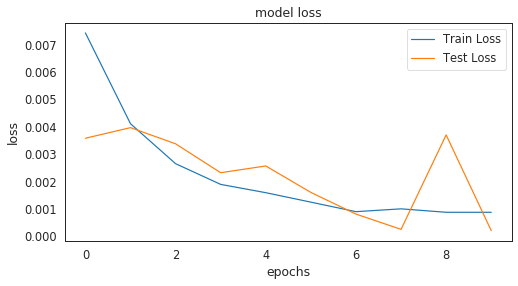

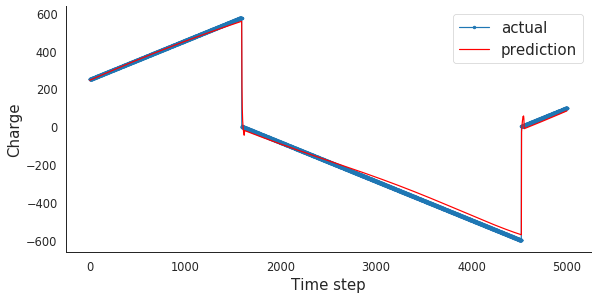

In [24]:
df=pd.read_csv('cell7.csv')
df = df.sort_values('t')
print('Number of rows and columns:', df.shape)
df.head(5)
# print(df.Global_active_power.describe())
sns.distplot(df.q);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.q)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.q)))
df1=df.loc[:,['t','q']]
df1.set_index('t',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('q')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Lithium-ion battery Time Series')
sns.despine(top=True)
plt.show();
dataset = df.q.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=10, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();
aa=[x for x in range(5000)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:5000], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:5000], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Charge', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

# cell8

Number of rows and columns: (415341, 4)
Kurtosis of normal distribution: -1.150522638920062
Skewness of normal distribution: 0.003387343145535124


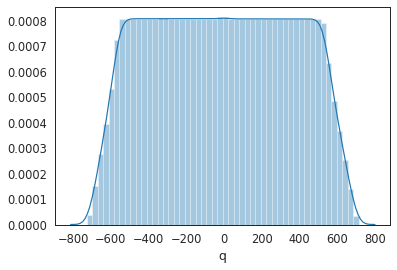

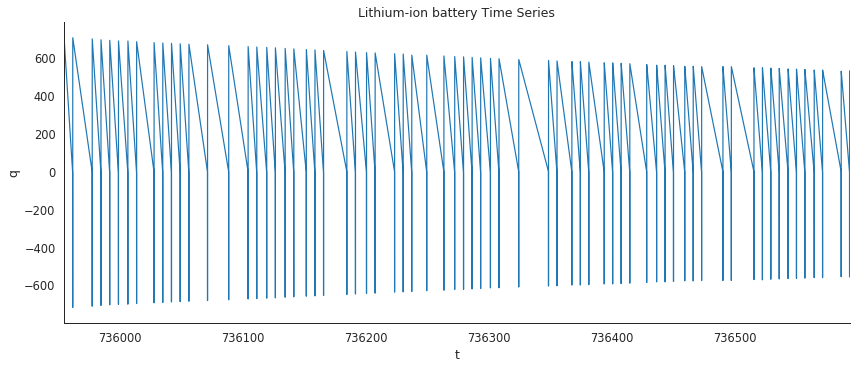

Train on 332241 samples, validate on 83038 samples
Epoch 1/10
332241/332241 [==============================] - 19s 57us/step - loss: 0.0075 - val_loss: 0.0049
Epoch 2/10
332241/332241 [==============================] - 18s 54us/step - loss: 0.0043 - val_loss: 0.0126
Epoch 3/10
332241/332241 [==============================] - 18s 54us/step - loss: 0.0028 - val_loss: 0.0049
Epoch 4/10
332241/332241 [==============================] - 18s 53us/step - loss: 0.0019 - val_loss: 0.0035
Epoch 5/10
332241/332241 [==============================] - 18s 53us/step - loss: 0.0016 - val_loss: 0.0026
Epoch 6/10
332241/332241 [==============================] - 18s 54us/step - loss: 0.0013 - val_loss: 0.0041
Epoch 7/10
332241/332241 [==============================] - 18s 53us/step - loss: 9.2430e-04 - val_loss: 0.0011
Epoch 8/10
332241/332241 [==============================] - 18s 53us/step - loss: 9.5751e-04 - val_loss: 4.9717e-04
Epoch 9/10
332241/332241 [==============================] - 18s 55us/step

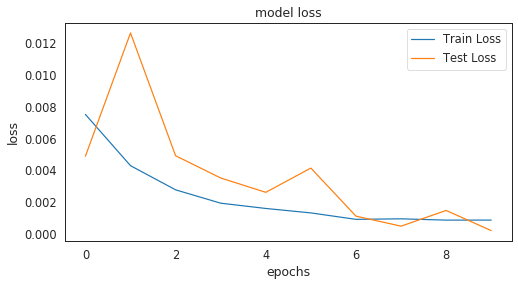

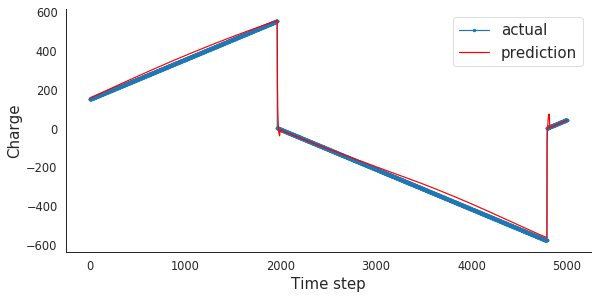

In [25]:
df=pd.read_csv('cell8.csv')
df = df.sort_values('t')
print('Number of rows and columns:', df.shape)
df.head(5)
# print(df.Global_active_power.describe())
sns.distplot(df.q);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.q)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.q)))
df1=df.loc[:,['t','q']]
df1.set_index('t',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('q')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Lithium-ion battery Time Series')
sns.despine(top=True)
plt.show();
dataset = df.q.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=10, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();
aa=[x for x in range(5000)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:5000], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:5000], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Charge', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();